In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from nltk.metrics.agreement import AnnotationTask
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import confusion_matrix
from scipy.stats import spearmanr as spearman
pilot_file = "Batch_3246275_batch_results.csv"
sid_pilot_file = "Batch_193589_batch_results_sid.csv"
import warnings
warnings.filterwarnings('ignore')

#### R packages install - Run only if running for the first time

In [2]:
# import rpy2.robjects.packages as rpackages
# utils = rpackages.importr('utils')
# utils.chooseCRANmirror(ind=1) 
# packnames = ('ggplot2', 'lme4', 'reshape2', 'tidyverse')
# from rpy2.robjects.vectors import StrVector
# utils.install_packages(StrVector(packnames))

In [3]:
#Load R packages:
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

In [4]:
data = pd.read_csv(pilot_file)
data.columns = [c.replace('.', '_') for c in data.columns]
#data.head()

In [5]:
def extract_dataframe(data):
    '''
    Input: Pandas csv dataframe obtained from MTurk
    
    Output: Pandas dataframe levelled by (User x Sentenced_ID)
    '''
    data["dicts"] = data["Input_var_arrays"].map(lambda x: json.loads(x))
    global_list = []
    
    for row in data.itertuples():
        for idx, local_dict in enumerate(row.dicts):
            temp_dict = local_dict.copy()
            var_instant = "Answer_instantaneous" + str(idx+1)
            var_instant_c =  "Answer_confidence_instantaneous" + str(idx+1)
            var_start = "Answer_startpt" + str(idx+1)
            var_start_c = "Answer_confidence_startpoint" + str(idx+1)
            var_end = "Answer_endpt" + str(idx+1)
            var_end_c = "Answer_confidence_endpoint" + str(idx+1)
            var_duration = "Answer_duration" + str(idx+1)
            var_duration_c = "Answer_confidence_duration" + str(idx+1)

            temp_dict["is_instant"] = getattr(row, var_instant)
            temp_dict["conf_instant"] = getattr(row, var_instant_c)
            temp_dict["has_start"] = getattr(row, var_start)
            temp_dict["conf_start"] = getattr(row, var_start_c)
            temp_dict["has_end"] = getattr(row, var_end)
            temp_dict["conf_end"] = getattr(row, var_end_c)
            temp_dict["duration"] = getattr(row, var_duration)
            temp_dict["conf_duration"] = getattr(row, var_duration_c)
            temp_dict["worker_id"] = row.WorkerId
            temp_dict["hit_id"] = row.HITId

            global_list.append(temp_dict)
            
    return pd.DataFrame(global_list)


In [6]:
pilot_data = extract_dataframe(data)

#Re-arrange the order 
cols = list(pilot_data.columns)
pilot_data = pilot_data[pilot_data.columns[::-1]]
#pilot_data = pilot_data[pilot_data.columns[::-1]].drop('sentence', axis=1)

#pilot_data.replace('na',np.NaN, inplace=True)
pilot_data.head
pilot_data['sent_token'] = pilot_data['sentence_id'] + "_" +\
                            pilot_data['pred_token'].map(lambda x: str(x))


In [7]:
#Convert datatypes to be consistent
pilot_data = pilot_data.convert_objects(convert_numeric=True)
pilot_data['duration'] = pilot_data['duration'].fillna(value=10)
pilot_data.fillna(-1, inplace=True)
pilot_data['conf_start'] = pilot_data['conf_start'].astype(np.int64)
pilot_data['conf_end'] = pilot_data['conf_end'].astype(np.int64)
pilot_data['conf_duration'] = pilot_data['conf_duration'].astype(np.int64)
pilot_data['duration'] = pilot_data['duration'].astype(np.int64)
pilot_data.dtypes

worker_id        object
sentence_id      object
sentence         object
pred_token        int64
pred             object
is_instant         bool
id                int64
hit_id           object
has_start        object
has_end          object
duration          int64
conf_start        int64
conf_instant      int64
conf_end          int64
conf_duration     int64
sent_token       object
dtype: object

In [8]:
#Change has_start and Has_end to True if instantaneous = True
pilot_data.loc[(pilot_data.is_instant == True), 
               ['has_start', 'has_end']] = "true", "true"

pilot_data.loc[(pilot_data.is_instant == True), 'conf_start'] = pilot_data.conf_instant
pilot_data.loc[(pilot_data.is_instant == True), 'conf_end'] = pilot_data.conf_instant


In [9]:
pilot_data.head()

,worker_id,sentence_id,sentence,pred_token,pred,is_instant,id,hit_id,has_start,has_end,duration,conf_start,conf_instant,conf_end,conf_duration,sent_token
0,A279YSE7NB16M0,en-ud-train.conllu 5784,"&lsqb; an error <span class=\""predicate\""> oc...",3,occurred,True,1,3G3AJKPCXLXEW35IXAFPZSB1AI4Y42,true,true,10,3,3,3,-1,en-ud-train.conllu 5784_3
1,A279YSE7NB16M0,en-ud-train.conllu 5784,"&lsqb; an error occurred while <span class=\""...",5,processing,False,2,3G3AJKPCXLXEW35IXAFPZSB1AI4Y42,false,false,8,3,3,3,3,en-ud-train.conllu 5784_5
2,A279YSE7NB16M0,en-ud-train.conllu 1010,"Adolf Hitler even <span class=\""predicate\""> ...",3,held,False,3,3G3AJKPCXLXEW35IXAFPZSB1AI4Y42,true,true,5,3,3,3,2,en-ud-train.conllu 1010_3
3,A279YSE7NB16M0,en-ud-train.conllu 1010,Adolf Hitler even held an exhibition of &#39; ...,15,curating,False,4,3G3AJKPCXLXEW35IXAFPZSB1AI4Y42,false,false,4,3,3,3,2,en-ud-train.conllu 1010_15
4,A279YSE7NB16M0,en-ud-train.conllu 5106,The central question behind the palace coup is...,20,acted,False,5,3G3AJKPCXLXEW35IXAFPZSB1AI4Y42,false,false,5,3,2,3,2,en-ud-train.conllu 5106_20


#### Run Mixed Effects Model in R

In [10]:
# Enables the %%R magic 
%load_ext rpy2.ipython

In [11]:
#load packages:
%R require(ggplot2); require(tidyr); require(lme4)
# library(sigmoid)
# library(reshape2)
# library(tidyverse)

array([1], dtype=int32)

##### Process Data in R

### Run Mixed Effects Model 

#### Is Instant

In [12]:
%%R -i pilot_data -o df_inst
#Modelling Is_instant

#Convert to factors
pilot_data$is_instant = as.factor(pilot_data$is_instant)
pilot_data$has_start = as.factor(pilot_data$has_start)
pilot_data$has_end = as.factor(pilot_data$has_end)

#Mixed Effects Model
model = glmer(is_instant~1+(1|worker_id) + (1|sent_token) + (1|hit_id), data=pilot_data,  family="binomial")

#Model intercepts:
df_inst = ranef(model)$worker_id
colnames(df_inst) <- c('intercept')

df_inst$glmer_intercept_inst = df_inst$intercept + -0.6876 #constant added manually
df_inst$worker_id <- rownames(df_inst) 

print(summary(model))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_instant ~ 1 + (1 | worker_id) + (1 | sent_token) + (1 | hit_id)
   Data: pilot_data

     AIC      BIC   logLik deviance df.resid 
  1228.8   1248.4   -610.4   1220.8      996 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1595 -0.6027 -0.3254  0.6484  3.4826 

Random effects:
 Groups     Name        Variance  Std.Dev. 
 sent_token (Intercept) 2.092e+00 1.446e+00
 worker_id  (Intercept) 1.802e+00 1.342e+00
 hit_id     (Intercept) 1.387e-10 1.178e-05
Number of obs: 1000, groups:  sent_token, 200; worker_id, 44; hit_id, 20

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  -0.6876     0.2569  -2.676  0.00744 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


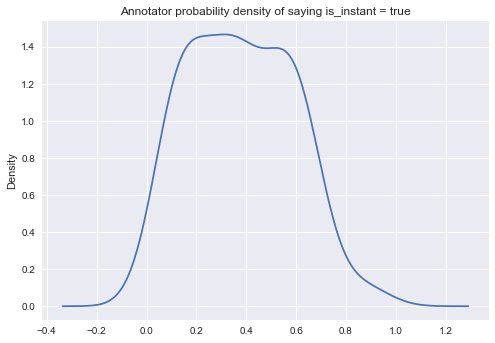

In [13]:
df_inst['glmer_intercept_inst'] = df_inst['glmer_intercept_inst'].apply(lambda x: 1/(1+np.exp(-x)))
df_inst.glmer_intercept_inst.plot(kind='density')
plt.title("Annotator probability density of saying is_instant = true")
plt.show()

#### Has_Start

In [14]:
%%R -i pilot_data -o df_start
#Modelling Is_instant

#Convert to factors
pilot_data$is_instant = as.factor(pilot_data$is_instant)
pilot_data$has_start = as.factor(pilot_data$has_start)
pilot_data$has_end = as.factor(pilot_data$has_end)

#Mixed Effects Model
model = glmer(has_start~1+(1|worker_id) + (1|sent_token) + (1|hit_id), data=pilot_data,  family="binomial")

#Model intercepts:
df_start = ranef(model)$worker_id
colnames(df_start) <- c('intercept')

df_start$glmer_intercept_start = df_start$intercept + 1.6617165 #constant added manually
df_start$worker_id <- rownames(df_start) 

print(summary(model))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: has_start ~ 1 + (1 | worker_id) + (1 | sent_token) + (1 | hit_id)
   Data: pilot_data

     AIC      BIC   logLik deviance df.resid 
  1045.1   1064.7   -518.5   1037.1      996 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0059 -0.4942  0.2293  0.4699  2.3911 

Random effects:
 Groups     Name        Variance Std.Dev.
 sent_token (Intercept) 2.551    1.597   
 worker_id  (Intercept) 2.414    1.554   
 hit_id     (Intercept) 0.000    0.000   
Number of obs: 1000, groups:  sent_token, 200; worker_id, 44; hit_id, 20

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) 1.6617165  0.0006848    2426   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
convergence code: 0
Model failed to converge with max|grad| = 0.103312 (tol = 0.001, component 1)
Model is nearly unidentifiable: very lar

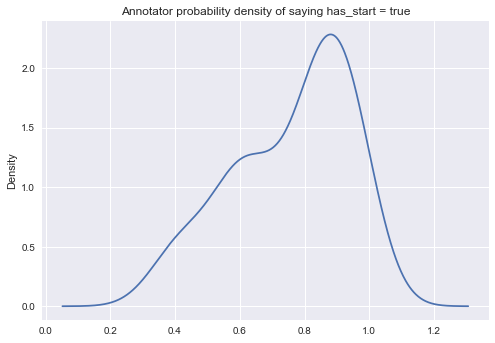

In [15]:
df_start['glmer_intercept_start'] = df_start['glmer_intercept_start'].apply(lambda x: 1/(1+np.exp(-x)))
df_start.glmer_intercept_start.plot(kind='density')
plt.title("Annotator probability density of saying has_start = true")
plt.show()

#### Has_End

In [16]:
%%R -i pilot_data -o df_end
#Modelling Is_instant

#Convert to factors
pilot_data$is_instant = as.factor(pilot_data$is_instant)
pilot_data$has_start = as.factor(pilot_data$has_start)
pilot_data$has_end = as.factor(pilot_data$has_end)

#Mixed Effects Model
model = glmer(has_end~1+(1|worker_id) + (1|sent_token) + (1|hit_id), data=pilot_data,  family="binomial")

#Model intercepts:
df_end = ranef(model)$worker_id
colnames(df_end) <- c('intercept')

df_end$glmer_intercept_end = df_end$intercept + 1.0041 #constant added manually
df_end$worker_id <- rownames(df_end) 

print(summary(model))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: has_end ~ 1 + (1 | worker_id) + (1 | sent_token) + (1 | hit_id)
   Data: pilot_data

     AIC      BIC   logLik deviance df.resid 
  1124.8   1144.5   -558.4   1116.8      996 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6541 -0.5951  0.2506  0.5393  2.1441 

Random effects:
 Groups     Name        Variance Std.Dev.
 sent_token (Intercept) 2.01421  1.4192  
 worker_id  (Intercept) 2.09677  1.4480  
 hit_id     (Intercept) 0.07767  0.2787  
Number of obs: 1000, groups:  sent_token, 200; worker_id, 44; hit_id, 20

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.0041     0.2781   3.611 0.000305 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


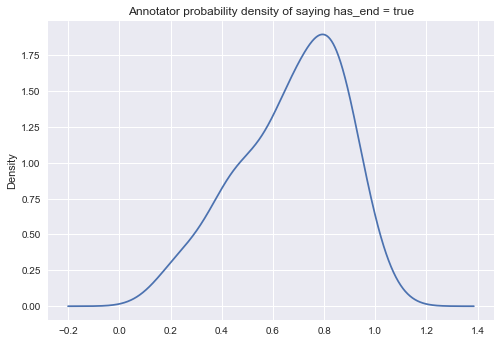

In [17]:
df_end['glmer_intercept_end'] = df_end['glmer_intercept_end'].apply(lambda x: 1/(1+np.exp(-x)))
df_end.glmer_intercept_end.plot(kind='density')
plt.title("Annotator probability density of saying has_end = true")
plt.show()

## Response distribution

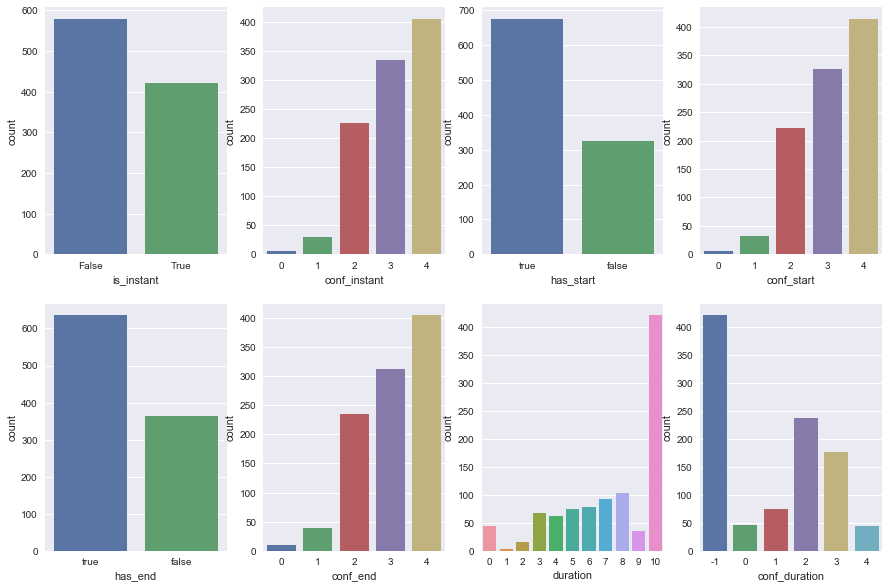

In [18]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 10))
sns.countplot(x='is_instant', data=pilot_data, ax=axs[0][0])
sns.countplot(x='conf_instant', data=pilot_data, ax=axs[0][1])
sns.countplot(x='has_start', data=pilot_data, ax=axs[0][2])
sns.countplot(x='conf_start', data=pilot_data, ax=axs[0][3])
sns.countplot(x='has_end', data=pilot_data, ax=axs[1][0])
sns.countplot(x='conf_end', data=pilot_data, ax=axs[1][1])
sns.countplot(x='duration', data=pilot_data, ax=axs[1][2])
sns.countplot(x='conf_duration', data=pilot_data, ax=axs[1][3])
plt.show()

## Inter-Annotator Agreement

### Raw Agreement

 #### 1. Stringent (Exact matches for a particular sent-predicate pair)

In [19]:
def calc_raw_agreement(data, key_var, check_var):
    '''
    Input: 
    1. data: Pandas dataframe
    2. key_var: variable based on which raw agreement is to be calculated
    3. check_var: vaiable on which raw agreement is calculated
    
    '''
    print("####### Raw Count for {} ###########".format(check_var))
    ids = set(list(data[key_var].values))

    total_count = len(ids)
    raw_count = 0
    keys = []
    
    for iden in ids:
        temp = list(data[data[key_var] == iden][check_var].values)
        if temp.count(temp[0]) == len(temp):
            raw_count += 1
            keys.append(iden)
     
    agreement = (raw_count/total_count)*100
    
    print("Total count of unique {} is {}".format(key_var, total_count))
    print("Raw count of matched for {} is {}".format(check_var, raw_count))
    print("Inter-annotator agreement for {} is {}%".format(check_var, agreement))
    print("\n")
    
    return agreement, keys

instant_agreement, key_inst = calc_raw_agreement(pilot_data, 'sent_token', 'is_instant')
start_agreement, key_start = calc_raw_agreement(pilot_data, 'sent_token', 'has_start')
end_agreement, key_end = calc_raw_agreement(pilot_data, 'sent_token', 'has_end')

####### Raw Count for is_instant ###########
Total count of unique sent_token is 200
Raw count of matched for is_instant is 52
Inter-annotator agreement for is_instant is 26.0%


####### Raw Count for has_start ###########
Total count of unique sent_token is 200
Raw count of matched for has_start is 59
Inter-annotator agreement for has_start is 29.5%


####### Raw Count for has_end ###########
Total count of unique sent_token is 200
Raw count of matched for has_end is 51
Inter-annotator agreement for has_end is 25.5%




#### 2. Kappa score estimation

In [20]:
print("Total number of annotators: {}".format(len(pilot_data['worker_id'].unique())))

Total number of annotators: 44


In [21]:
def extract_pairs_of_workers(data, worker_id):
    '''
    Given a pandas dataframe, and worker_id variable,
    extracts a list of pairs of worker_ids
    '''
    workers = list(set(data[worker_id].values))
    
    return list(itertools.combinations(workers, 2))

def extract_worker_sent_dict(data, worker_id, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    workers = list(set(data[worker_id].values))
    
    ans = {}
    
    for worker in workers:
        sents = set(list(data[data[worker_id] == worker][sent_id].values))
        ans[worker] = sents
        
    return ans

def extract_worker_pair_dict(data, worker_pairs, worker_dict, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    ans = {}
    
    for (w1, w2) in worker_pairs:
        common_set = worker_dict[w1].intersection(worker_dict[w2])
        if common_set != set():
            ans[(w1,w2)] = list(common_set)
        
    return ans

In [22]:
worker_pairs = extract_pairs_of_workers(pilot_data, 'worker_id')
worker_dict = extract_worker_sent_dict(pilot_data, 'worker_id', 'sent_token')
worker_pair_dict = extract_worker_pair_dict(pilot_data, worker_pairs, worker_dict,'sent_token')

#### Standard Kappa

In [23]:
def average_metric_nltk(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score or any other metric 
    
    Output: average kappa score, alpha score for (pairs of annotators) in the dataset.

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    kappas = []
    alphas = []
    
    for (w1, w2) in worker_pairs:
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        
        if common_set == set():
            continue
            
        temp_data = []
        
        for key in common_set:
            val3 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val4 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values 
            temp_data.append((w1,key, val3[0]))
            temp_data.append((w2,key, val4[0]))

        task = AnnotationTask(data=temp_data)
        try:
            kappas.append(task.kappa())
            alphas.append(task.alpha())
        except:
            print("Cannot calculate alpha, expected disagreement zero!")

    return kappas, alphas

def average_metric_sklearn(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score or any other metric 
    
    Output: average kappa score, accuracy and spearman correlation for (pairs of annotators) in the dataset.

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    kappas = []
    accuracies = []
    
    for (w1, w2) in worker_pairs:
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        
        if common_set == set():
            continue
            
        temp1 = []
        temp2 = []
        
        if check_var != 'is_instant':
            for key in common_set:
                val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)]['is_instant'].values
                val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)]['is_instant'].values
                #Only compute metrics if both annotators mark not-instantaneous
                if val1[0] == False and val2[0]== False:
                    val3 = data[(data[key_var] == key) & 
                            (data[worker_id] == w1)][check_var].values
                    val4 = data[(data[key_var] == key) & 
                            (data[worker_id] == w2)][check_var].values 
                    temp1.append(val3[0])
                    temp2.append(val4[0])     
                else:
                    continue     
        
        else: #check_var == 'is_instant'
            for key in common_set:
                val3 = data[(data[key_var] == key) & 
                            (data[worker_id] == w1)][check_var].values
                val4 = data[(data[key_var] == key) & 
                            (data[worker_id] == w2)][check_var].values 
                temp1.append(val3[0])
                temp2.append(val4[0])
                   
        if temp1 == [] or temp2 == []:
            continue

        elif temp1==temp2:
            kappas.append(1.0)
        else:
            kappas.append(kappa(temp1, temp2))
        accuracies.append(accuracy(temp1, temp2))
                
    return kappas, accuracies  

In [24]:
kappas = {}
accuracies = {}
vars_temp = ['is_instant', 'has_start', 'has_end']
for var in vars_temp:
    kappas[var], accuracies[var] = average_metric_sklearn(pilot_data, 'worker_id', 'sent_token', var)
    print("{} -- Completed!".format(var))

is_instant -- Completed!
has_start -- Completed!
has_end -- Completed!


In [25]:
kappa_data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in kappas.items() ]))
acc_data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in accuracies.items() ]))

In [26]:
print('Average Kappa for "is_instant" variable: {}'.format(np.mean(kappa_data['is_instant'])))
print('Average Kappa for "has_start" variable: {}'.format(np.mean(kappa_data['has_start'])))
print('Average Kappa for "has_end" variable: {}'.format(np.mean(kappa_data['has_end'])))
print("\n")


print('Average Accuracy for "is_instant" variable: {}'.format(np.mean(acc_data['is_instant'])))
print('Average Accuracy for "has_start" variable: {}'.format(np.mean(acc_data['has_start'])))
print('Average Accuracy for "has_end" variable: {}'.format(np.mean(acc_data['has_end'])))
print("\n")

Average Kappa for "is_instant" variable: 0.20180921009067299
Average Kappa for "has_start" variable: 0.25734488012178797
Average Kappa for "has_end" variable: 0.2477987382395042


Average Accuracy for "is_instant" variable: 0.6104431216931219
Average Accuracy for "has_start" variable: 0.5712943415182541
Average Accuracy for "has_end" variable: 0.6022251698040362




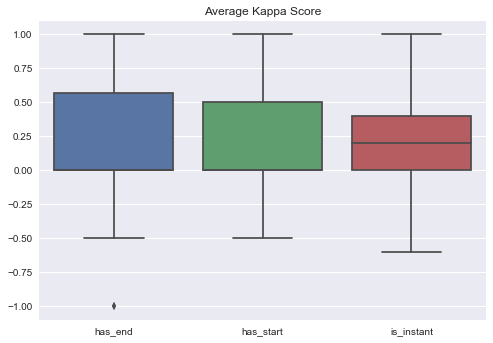

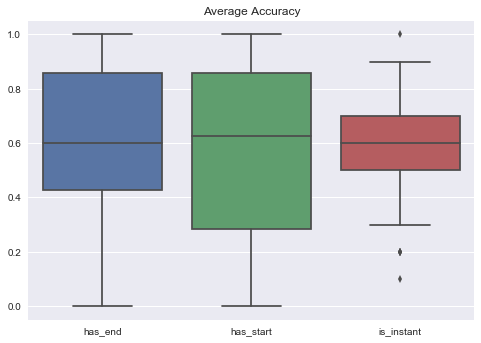

In [27]:
ax = sns.boxplot(data=kappa_data)
ax.set(title="Average Kappa Score")
plt.show()

ax = sns.boxplot(data=acc_data)
ax.set(title="Average Accuracy")
plt.show()


#### Kappa with estimated chance probabilities

In [28]:
def worker_pair_prob(prob_data, worker_pair_dict, prob_var, worker_var):
    '''
    Outputs a dict with 
    key: worker pair
    value: probability of workers agreeing by chance after taking into account the mixed effects model
    '''
    pair_prob_dict = {}
    
    for an1, an2 in worker_pair_dict:
        p1 = prob_data[prob_data[worker_var] == an1][prob_var][0]
        p2 = prob_data[prob_data[worker_var] == an2][prob_var][0]
        pe = p1*p2 + ((1-p1)*(1-p2))
        
        pair_prob_dict[(an1, an2)] = pe
        
    return pair_prob_dict

In [29]:
pair_prob_dict = {}
pair_prob_dict['is_instant'] = worker_pair_prob(df_inst, worker_pair_dict, 'glmer_intercept_inst','worker_id')
pair_prob_dict['has_start'] = worker_pair_prob(df_start, worker_pair_dict, 'glmer_intercept_start','worker_id')
pair_prob_dict['has_end'] = worker_pair_prob(df_end, worker_pair_dict, 'glmer_intercept_end','worker_id')

In [30]:
def average_estimated_kappa(data, worker_id, key_var, check_var, pe_prob):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score or any other metric 
    
    Output: average kappa score, accuracy and spearman correlation for (pairs of annotators) in the dataset.

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    kappas = []
    accuracies = []
    
    for (w1, w2) in worker_pairs:
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        
        if common_set == set():
            continue
            
        temp1 = []
        temp2 = []
        
        if check_var != 'is_instant':
            for key in common_set:
                val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)]['is_instant'].values
                val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)]['is_instant'].values
                #Only compute metrics if both annotators mark not-instantaneous
                if val1[0] == False and val2[0]== False:
                    val3 = data[(data[key_var] == key) & 
                            (data[worker_id] == w1)][check_var].values
                    val4 = data[(data[key_var] == key) & 
                            (data[worker_id] == w2)][check_var].values 
                    temp1.append(val3[0])
                    temp2.append(val4[0])     
                else:
                    continue     
        else: #check_var == 'is_instant'
            for key in common_set:
                val3 = data[(data[key_var] == key) & 
                            (data[worker_id] == w1)][check_var].values
                val4 = data[(data[key_var] == key) & 
                            (data[worker_id] == w2)][check_var].values 
                temp1.append(val3[0])
                temp2.append(val4[0])
                   
        if temp1 == [] or temp2 == []:
            continue
            
        elif temp1==temp2:
            kappas.append(1.0)
            accuracies.append(1.0)
        else:
            po = accuracy(temp1, temp2)
            pe = pe_prob[(w1, w2)]
            kappas.append((po-pe)/(1-pe))
            accuracies.append(po)
        
    return kappas, accuracies 

In [31]:
var_list = ['is_instant', 'has_start', 'has_end']
kappas = {}
accuracies = {}
for var in var_list:
    kappas[var], accuracies[var] = average_estimated_kappa(pilot_data, 'worker_id', 
                                                            'sent_token', var, pair_prob_dict[var])
    print("{} -- Completed!".format(var))

is_instant -- Completed!
has_start -- Completed!
has_end -- Completed!


In [32]:
kappa_data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in kappas.items() ]))
accuracy_data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in accuracies.items() ]))

In [33]:
print('Average Kappa for "is_instant" variable: {}'.format(np.mean(kappa_data['is_instant'])))
print('Average Kappa for "has_start" variable: {}'.format(np.mean(kappa_data['has_start'])))
print('Average Kappa for "has_end" variable: {}'.format(np.mean(kappa_data['has_end'])))
print("\n")

Average Kappa for "is_instant" variable: 0.19020148286752614
Average Kappa for "has_start" variable: -0.1932971883992204
Average Kappa for "has_end" variable: 0.040284493511703774




#### Mean Pe values

In [34]:
np.mean([pair_prob_dict['is_instant'][key] for key in pair_prob_dict['is_instant']])

0.5187543416387482

In [35]:
np.mean([pair_prob_dict['has_start'][key] for key in pair_prob_dict['has_start']])

0.5899542245802114

In [36]:
np.mean([pair_prob_dict['has_end'][key] for key in pair_prob_dict['has_end']])

0.5488676494638344

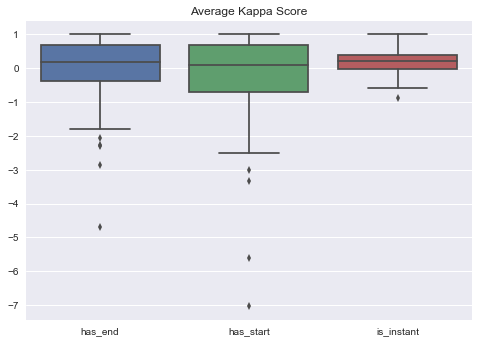

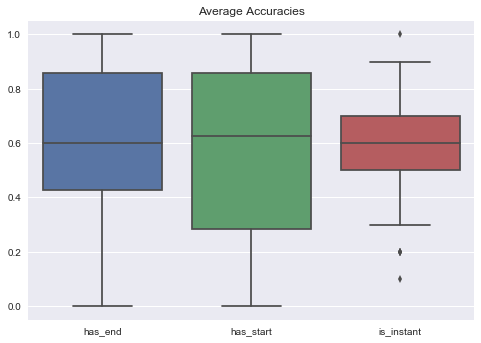

In [37]:
ax = sns.boxplot(data=kappa_data)
ax.set(title="Average Kappa Score")
plt.show()

ax = sns.boxplot(data=accuracy_data)
ax.set(title="Average Accuracies")
plt.show()

# ax = sns.boxplot(data=corrs_data)
# ax.set(title="Average Spearman Correlation")
# plt.show()

## Correlation Coefficients for Confidence Agreement

In [38]:
def average_correlation(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score or any other metric 
    
    Output: average kappa score, accuracy and spearman correlation for (pairs of annotators) in the dataset.

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    spearmans = []
    
    for (w1, w2) in worker_pairs:
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        
        if common_set == set():
            continue
            
        temp1 = []
        temp2 = []
        
        if check_var != 'is_instant':
            for key in common_set:
                val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)]['is_instant'].values
                val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)]['is_instant'].values
                #Only compute metrics if both annotators mark not-instantaneous
                if val1[0] == False and val2[0]== False:
                    val3 = data[(data[key_var] == key) & 
                            (data[worker_id] == w1)][check_var].values
                    val4 = data[(data[key_var] == key) & 
                            (data[worker_id] == w2)][check_var].values 
                    temp1.append(val3[0])
                    temp2.append(val4[0])     
                else:
                    continue     
        else: #check_var == 'is_instant'
            for key in common_set:
                val3 = data[(data[key_var] == key) & 
                            (data[worker_id] == w1)][check_var].values
                val4 = data[(data[key_var] == key) & 
                            (data[worker_id] == w2)][check_var].values 
                temp1.append(val3[0])
                temp2.append(val4[0])
                   
        if temp1 == [] or temp2 == []:
            continue
        elif temp1 == temp2:
            spearmans.append(1.0)
        else: 
            spearmans.append(spearman(temp1, temp2)[0])
            
    return spearmans 

In [39]:
var_list = ['conf_duration', 'conf_start', 'conf_end', 'conf_instant', 'duration']
corrs = {}
for var in var_list:
    corrs[var] = average_correlation(pilot_data, 'worker_id', 
                                                            'sent_token', var)
    print("{} -- Completed!".format(var))

conf_duration -- Completed!
conf_start -- Completed!
conf_end -- Completed!
conf_instant -- Completed!
duration -- Completed!


In [40]:
corr_data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in corrs.items() ]))

In [41]:
corr_data.head(10)

,conf_duration,conf_end,conf_instant,conf_start,duration
0,0.000000,NaN,NaN,NaN,0.215686
1,0.447214,NaN,-0.141421,NaN,0.772727
2,0.000000,NaN,-0.316228,NaN,0.419921
3,-0.416667,NaN,0.509175,NaN,0.670995
4,NaN,NaN,NaN,NaN,NaN
5,-0.400000,0.353553,0.645497,NaN,0.368605
6,0.645497,-0.540062,0.683130,NaN,0.204124
7,1.000000,NaN,-0.333333,NaN,1.000000
8,NaN,-1.000000,-1.000000,NaN,NaN
9,-0.200000,0.000000,NaN,0.0,-0.516100


In [42]:
print('Average Correlation for conf "duration" variable: {}'.format(np.nanmean(corr_data['conf_duration'])))
print('Average Correlation for conf "start" variable: {}'.format(np.nanmean(corr_data['conf_start'])))
print('Average Correlation for conf "end" variable: {}'.format(np.nanmean(corr_data['conf_end'])))
print('Average Correlation for conf "instant" variable: {}'.format(np.nanmean(corr_data['conf_instant'])))
print('Average Correlation for "duration" variable: {}'.format(np.nanmean(corr_data['duration'])))
print("\n")

Average Correlation for conf "duration" variable: 0.1571591742778399
Average Correlation for conf "start" variable: 0.20173246800694364
Average Correlation for conf "end" variable: 0.13650139949719728
Average Correlation for conf "instant" variable: 0.13559533491448403
Average Correlation for "duration" variable: 0.3125084072474516




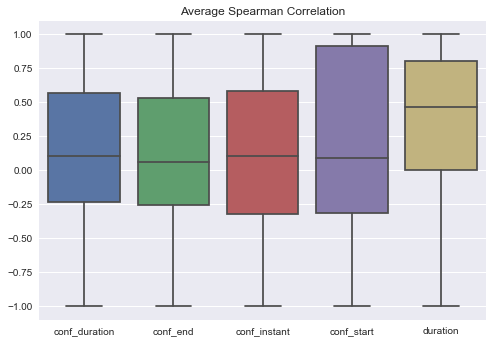

In [43]:
ax = sns.boxplot(data=corr_data)
ax.set(title="Average Spearman Correlation")
plt.show()

### Confusion Matrix - Duration

In [44]:
duration_dict = {10: 'instant', 9: 'secs',8:'mins', 7:'hrs', 6:'days',
                5:'weeks', 4:'months', 3:'yrs', 2:'decs', 1:'cent', 0:'forever'}

pilot_data['duration_tag'] = pilot_data.apply(lambda row : duration_dict[row.duration], axis=1)

In [45]:
duration_tags = ['secs','mins','hrs','days','weeks','months','yrs','decs','cent','forever']
print(duration_tags)

['secs', 'mins', 'hrs', 'days', 'weeks', 'months', 'yrs', 'decs', 'cent', 'forever']


In [46]:
def average_confusion_matrix(data, worker_id, key_var, check_var, label_list):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score or any other metric 
    
    Output: average kappa score, accuracy and spearman correlation for (pairs of annotators) in the dataset.

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    conf_list = []
    conf_rev_list = []
    
    for (w1, w2) in worker_pairs:
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        
        if common_set == set():
            continue
            
        temp1 = []
        temp2 = []
        
        if check_var != 'is_instant':
            for key in common_set:
                val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)]['is_instant'].values
                val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)]['is_instant'].values
                #Only compute metrics if both annotators mark not-instantaneous
                if val1[0] == False and val2[0]== False:
                    val3 = data[(data[key_var] == key) & 
                            (data[worker_id] == w1)][check_var].values
                    val4 = data[(data[key_var] == key) & 
                            (data[worker_id] == w2)][check_var].values 
                    temp1.append(val3[0])
                    temp2.append(val4[0])     
                else:
                    continue     
        else: #check_var == 'is_instant'
            for key in common_set:
                val3 = data[(data[key_var] == key) & 
                            (data[worker_id] == w1)][check_var].values
                val4 = data[(data[key_var] == key) & 
                            (data[worker_id] == w2)][check_var].values 
                temp1.append(val3[0])
                temp2.append(val4[0])
                   
        if temp1 == [] or temp2 == []:
            continue

        conf_matrix = confusion_matrix(temp1, temp2, labels=label_list)
        conf_matrix_rev = confusion_matrix(temp2, temp1, labels=label_list)
        
        #NORMALISE
        sum_a = np.sum(conf_matrix,axis=None)
        sum_rev = np.sum(conf_matrix_rev,axis=None)
        
        #conf_matrix = conf_matrix/sum_a
        #conf_matrix_rev = conf_matrix_rev/sum_rev
        
        conf_list.append(conf_matrix)
        conf_rev_list.append(conf_matrix_rev)
        
                
    return conf_list, conf_rev_list

def matprint(mat, fmt="g"):
    '''
    Pretty print a numpy matrix
    
    Source: https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
    '''
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")
        
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [47]:
conf_list, conf_rev_list = average_confusion_matrix(pilot_data, 'worker_id', 
                                                    'sent_token', 'duration_tag', duration_tags)

#### Summed-up Symmetric Matrix

In [48]:
A = sum(conf_list) + sum(conf_list).T
B = sum(conf_rev_list) + sum(conf_rev_list).T

A = A/np.sum(A, axis=None)
B = B/np.sum(B, axis=None)
#matprint(A)

Confusion matrix, without normalization
[[0.00640205 0.00960307 0.00896287 0.00320102 0.00512164 0.
  0.00512164 0.00128041 0.0006402  0.00256082]
 [0.00960307 0.04609475 0.0396927  0.01600512 0.00768246 0.00448143
  0.00576184 0.00128041 0.00128041 0.01472471]
 [0.00896287 0.0396927  0.05377721 0.02240717 0.01152369 0.00512164
  0.00448143 0.00192061 0.0006402  0.01088348]
 [0.00320102 0.01600512 0.02240717 0.03841229 0.02368758 0.0128041
  0.00832266 0.00128041 0.         0.01152369]
 [0.00512164 0.00768246 0.01152369 0.02368758 0.03329065 0.0268886
  0.0134443  0.00256082 0.         0.00960307]
 [0.         0.00448143 0.00512164 0.0128041  0.0268886  0.02176697
  0.03777209 0.00320102 0.0006402  0.00640205]
 [0.00512164 0.00576184 0.00448143 0.00832266 0.0134443  0.03777209
  0.03585147 0.0134443  0.00192061 0.01216389]
 [0.00128041 0.00128041 0.00192061 0.00128041 0.00256082 0.00320102
  0.0134443  0.00896287 0.0006402  0.00192061]
 [0.0006402  0.00128041 0.0006402  0.         0.  

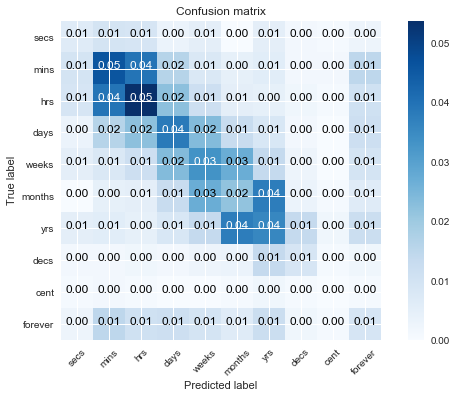

In [49]:
plt.figure()
plot_confusion_matrix(A, classes=duration_tags, normalize=False,
                      title='Confusion matrix')

plt.show()

### Sid's annotation

In [50]:
sid_data = pd.read_csv(sid_pilot_file)
sid_data.columns = [c.replace('.', '_') for c in sid_data.columns]
#data.head()

sid_pilot_data = extract_dataframe(sid_data)

#Re-arrange the order 
cols = list(sid_pilot_data.columns)
sid_pilot_data = sid_pilot_data[sid_pilot_data.columns[::-1]]
#sid_pilot_data = sid_pilot_data[sid_pilot_data.columns[::-1]].drop('sentence', axis=1)


sid_pilot_data['sent_token'] = sid_pilot_data['sentence_id'] + "_" +\
                            sid_pilot_data['pred_token'].map(lambda x: str(x))

    
#Convert datatypes to be consistent
sid_pilot_data = sid_pilot_data.convert_objects(convert_numeric=True)
sid_pilot_data['duration'] = sid_pilot_data['duration'].fillna(value=10)
sid_pilot_data.fillna(-1, inplace=True)
sid_pilot_data['conf_start'] = sid_pilot_data['conf_start'].astype(np.int64)
sid_pilot_data['conf_end'] = sid_pilot_data['conf_end'].astype(np.int64)
sid_pilot_data['conf_duration'] = sid_pilot_data['conf_duration'].astype(np.int64)
sid_pilot_data['duration'] = sid_pilot_data['duration'].astype(np.int64)


#Duration_tag
sid_pilot_data['duration_tag'] = sid_pilot_data.apply(lambda row : duration_dict[row.duration], axis=1)

sid_pilot_data.head()

,worker_id,sentence_id,sentence,pred_token,pred,is_instant,id,hit_id,has_start,has_end,duration,conf_start,conf_instant,conf_end,conf_duration,sent_token,duration_tag
0,A2GL712W3LDMFO,en-ud-train.conllu 6791,( He already had the traumas that his previous...,13,caused,False,1,3NOEP8XAU42P3B5B0WQA1J8WXFDPXU,true,false,8,2,3,2,2,en-ud-train.conllu 6791_13,mins
1,A2GL712W3LDMFO,en-ud-train.conllu 6791,( He already had the traumas that his previous...,17,made,True,2,3NOEP8XAU42P3B5B0WQA1J8WXFDPXU,na,na,10,-1,2,-1,-1,en-ud-train.conllu 6791_17,instant
2,A2GL712W3LDMFO,en-ud-train.conllu 12133,The price was actually lower than what I had ...,9,anticipated,True,3,3NOEP8XAU42P3B5B0WQA1J8WXFDPXU,na,na,10,-1,2,-1,-1,en-ud-train.conllu 12133_9,instant
3,A2GL712W3LDMFO,en-ud-train.conllu 12133,The price was actually lower than what I had a...,25,did,False,4,3NOEP8XAU42P3B5B0WQA1J8WXFDPXU,false,true,7,2,2,2,2,en-ud-train.conllu 12133_25,hrs
4,A2GL712W3LDMFO,en-ud-train.conllu 6800,"When John <span class=\""predicate\""> asked</s...",2,asked,True,5,3NOEP8XAU42P3B5B0WQA1J8WXFDPXU,na,na,10,-1,3,-1,-1,en-ud-train.conllu 6800_2,instant


### Agreement Dataset (at sentence level)

In [51]:
sent_tokens = list(pilot_data.sent_token.unique())

#Sent_token and sentence pairs
g = pilot_data.groupby(['sent_token' ,'sentence'])
sent_groups = dict(list(g.groups.keys()))

In [52]:
agree_data = pd.DataFrame(sent_tokens, columns = ['sent_token'])

In [53]:
def tag_counts(row, data, time_tag, tag_var, sent_id):
    '''
    Count the number of a particular time_tag for a particular sentence id 
    as annotated by different annotators
    '''
    
    ans = list(data[data.sent_token == getattr(row, sent_id)][tag_var].values).count(time_tag)
    
    return ans

In [54]:
duration_tags = ['instant', 'secs','mins','hrs','days','weeks','months','yrs','decs','cent','forever']


for tag in duration_tags:
    agree_data[tag] = agree_data.apply(lambda row: tag_counts(row, pilot_data, tag, 
                                                              'duration_tag',  'sent_token'), axis=1)

In [55]:
agree_data.head()

,sent_token,instant,secs,mins,hrs,days,weeks,months,yrs,decs,cent,forever
0,en-ud-train.conllu 5784_3,4,0,1,0,0,0,0,0,0,0,0
1,en-ud-train.conllu 5784_5,1,0,2,2,0,0,0,0,0,0,0
2,en-ud-train.conllu 1010_3,1,0,0,1,1,2,0,0,0,0,0
3,en-ud-train.conllu 1010_15,0,0,0,0,1,2,2,0,0,0,0
4,en-ud-train.conllu 5106_20,0,0,0,0,1,3,1,0,0,0,0


#### Left Join Sid's duration_tags and sentences

In [56]:
temp_data = sid_pilot_data.rename(columns={"duration_tag": "sid_tag"})
temp_data = temp_data[['sent_token', 'sid_tag']]
temp_data.head()

,sent_token,sid_tag
0,en-ud-train.conllu 6791_13,mins
1,en-ud-train.conllu 6791_17,instant
2,en-ud-train.conllu 12133_9,instant
3,en-ud-train.conllu 12133_25,hrs
4,en-ud-train.conllu 6800_2,instant


In [57]:
agree_data = pd.merge(agree_data, temp_data, on = 'sent_token', how='left')
agree_data['sentence'] = agree_data.apply(lambda row: sent_groups[row.sent_token], axis=1)

In [58]:
agree_data['ann_agreement'] = agree_data.apply(lambda row: max(row.instant, row.secs, row.mins, row.hrs,
                                                         row.days, row.weeks, row.months, row.yrs, row.decs,
                                                         row.cent, row.forever), axis=1)
agree_data['mode_tag'] = agree_data[duration_tags].idxmax(axis=1)

In [59]:
agree_data.tail()

,sent_token,instant,secs,mins,hrs,days,weeks,months,yrs,decs,cent,forever,sid_tag,sentence,ann_agreement,mode_tag
195,en-ud-dev.conllu 19_12,4,0,0,0,0,0,0,0,0,0,1,instant,"They work on Wall Street , after all , so when...",4,instant
196,en-ud-dev.conllu 807_5,5,0,0,0,0,0,0,0,0,0,0,instant,"lol , last news message <span class=\""predica...",5,instant
197,en-ud-dev.conllu 807_12,1,0,3,0,0,0,0,0,0,0,1,secs,"lol , last news message came out kinda weird ,...",3,mins
198,en-ud-dev.conllu 13_6,2,0,1,0,2,0,0,0,0,0,0,hrs,"In Fallujah , hundreds of demonstrators <span...",2,instant
199,en-ud-dev.conllu 13_14,4,0,1,0,0,0,0,0,0,0,0,instant,"In Fallujah , hundreds of demonstrators came o...",4,instant


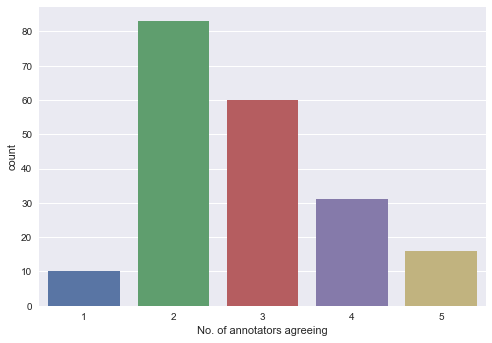

In [60]:
sns.countplot(x='ann_agreement', data=agree_data)
plt.xlabel("No. of annotators agreeing")
plt.show()

In [61]:
agree_data.ann_agreement.value_counts()

2    83
3    60
4    31
5    16
1    10
Name: ann_agreement, dtype: int64

#### Cumulative annotator agreement (raw)

In [62]:
agree_dict = dict(agree_data.ann_agreement.value_counts())

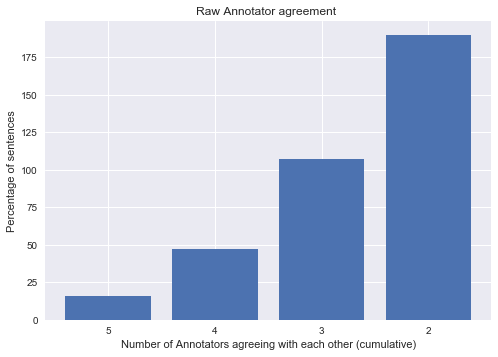

In [63]:
agrees = [agree_dict[5], agree_dict[5]+agree_dict[4],
                   agree_dict[5]+agree_dict[4]+agree_dict[3],
                   agree_dict[5]+agree_dict[4]+agree_dict[3]+agree_dict[2]]

degree = ['5', '4', '3', '2']

plt.bar(degree, agrees)
plt.xlabel("Number of Annotators agreeing with each other (cumulative)")
plt.ylabel("Percentage of sentences")
plt.title("Raw Annotator agreement ")
plt.show()

### Further Analysis of Sentences

In [64]:
agree_data[agree_data.sid_tag == agree_data.mode_tag].shape

(93, 16)

The above number shows that 93/170 times sid's answer was matched by the majority-annotator answer

In [65]:
agree_data.to_csv("agreement_data_protocol1.csv", index=False)

#### Manual sentence examples

https://bit.ly/2IYTicT